In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

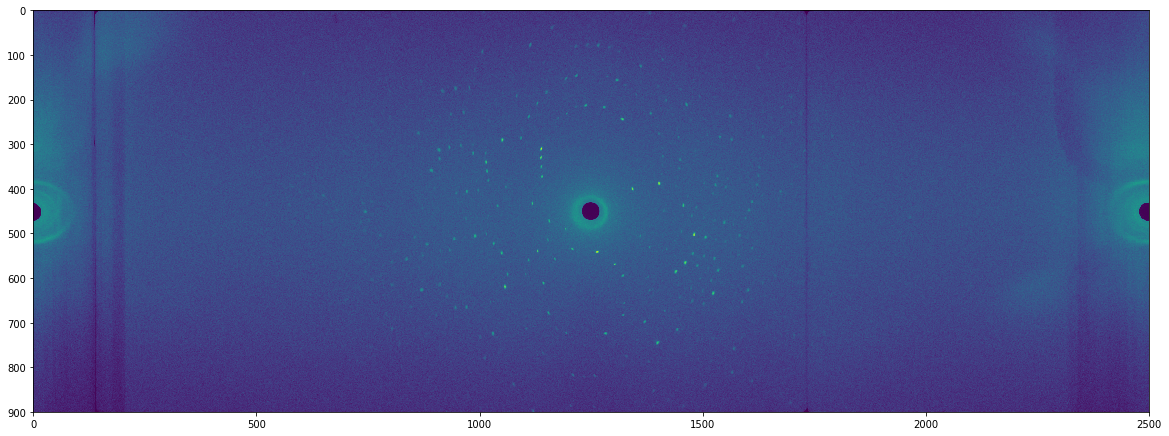

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.frame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
peaks = finder.find([data])
print(peaks.size())

9203


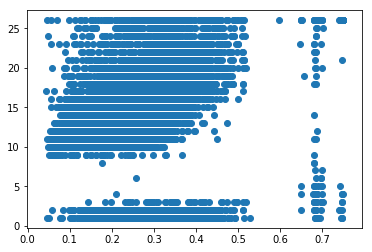

In [10]:
qs = []
slices = []

for p in peaks:
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.show()

In [8]:
data.integratePeaks(peaks, 3.5, 6.0, nsx.ProgressHandler())

In [11]:
for peak in peaks:
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)

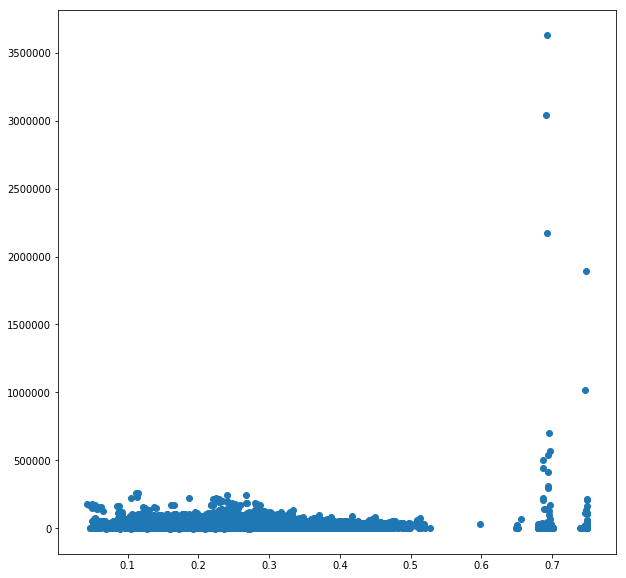

In [12]:
plot_I_vs_q(peaks)

7738


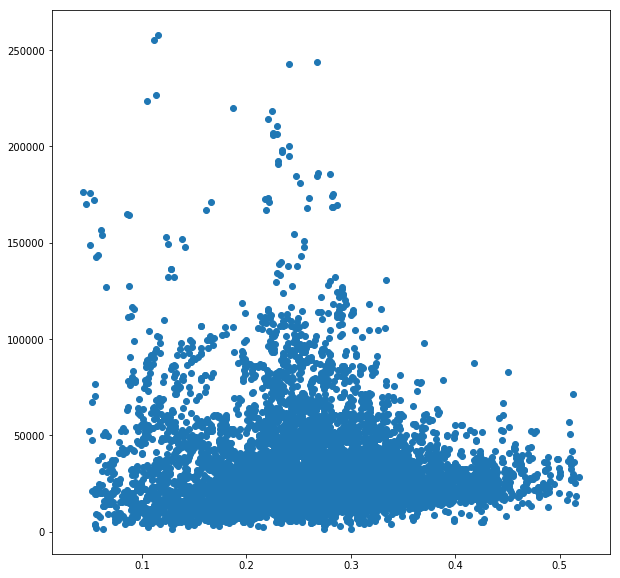

In [13]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [14]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = np.array([[0.,0.,0.]])
    if uc.getMillerIndices(peak.getQ(), hkl):
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 7738 peaks
indexed 7524 of 7738
found unit cell with parameters: 
a:  54.88508945691028
b:  58.60990054505923
c:  67.23994494666374
alpha:  1.5707963267948968
beta:  1.5707963267948966
gamma:  1.5707963267948966


In [15]:
plot_dq_vs_frame(indexed_peaks)
plot_dx_vs_frame(indexed_peaks, 10)

AttributeError: 'MillerIndex' object has no attribute 'dot'

In [26]:
data.nFrames()
nbatches

11

In [18]:
nbatches = int(data.nFrames() / 15)
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


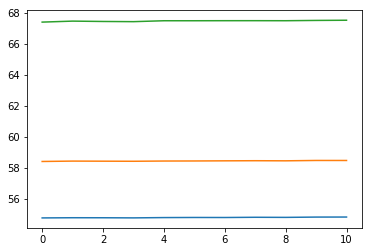

In [19]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

In [22]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)
plot_dx_vs_frame(refined_peaks)

AttributeError: 'MillerIndex' object has no attribute 'dot'

sample position


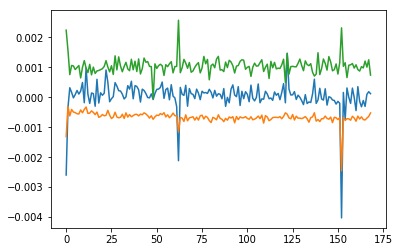

sample orientation perturbation


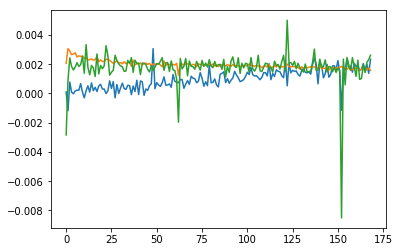

nx, ny


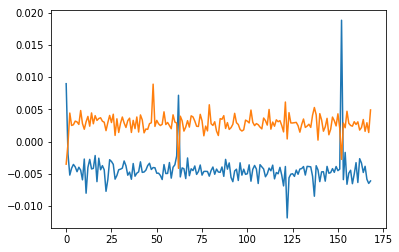

In [23]:
print("sample position")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, ny")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [24]:
len(refined_peaks)
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.979229134585425,
 'CCtrue': 0.9947389497657717,
 'Rmeas': 0.057842135751430254,
 'Rmerge': 0.04604777249403014,
 'Rpim': 0.034345205020226935}

In [19]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [20]:
peak_set = nsx.PeakSet()

for peak in refined_peaks:
    peak_set.insert(peak)

In [21]:
data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9904937150918622,
 'CCtrue': 0.9976092207298253,
 'Rmeas': 0.04631698671067603,
 'Rmerge': 0.03707108237743866,
 'Rpim': 0.027193672737600955}

In [54]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.diffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred
    
predicted = predict_peaks(refined_peaks, data, 1.5, 50.0, uc.reciprocalBasis(), refiner.batches())

In [55]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak_set.insert(peak)

data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9170881197231436,
 'CCtrue': 0.9781365638863175,
 'Rmeas': 0.23692086323143532,
 'Rmerge': 0.18759577857849077,
 'Rpim': 0.14190848428550146}

In [64]:
high_q = nsx.PeakSet()

for p in predicted:
    q = np.linalg.norm(p.getQ().rowVector())
    d = 1 / q
    if d < 1.5 or d > 1.8:
        continue
        
    high_q.append(p)
    
print(len(high_q))
data.integratePeaks(high_q, 3.0, 5.0, nsx.ProgressHandler())
compute_statistics(high_q, nsx.SpaceGroup("P 21 21 21"), True)

15309


{'CChalf': 0.6313506866777233,
 'CCtrue': 0.8797852192259584,
 'Rmeas': 0.709313461456085,
 'Rmerge': 0.5502782746080234,
 'Rpim': 0.4394974767526476}

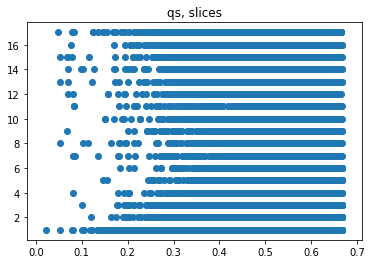

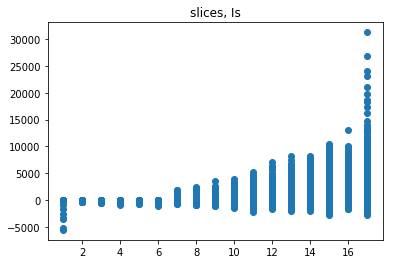

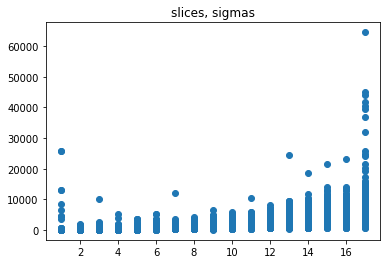

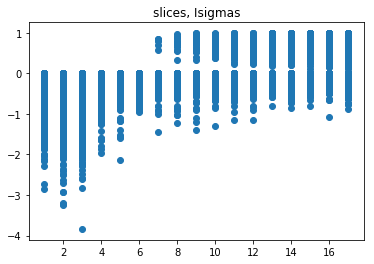

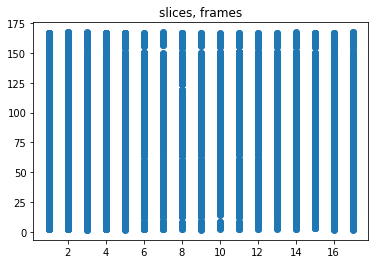

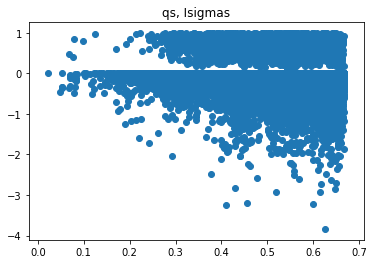

In [62]:
qs = []
slices = []
Is = []
sigmas = []
Isigmas = []
frames = []

for p in predicted:
    inten = p.getCorrectedIntensity()
    isigma = inten.value() / (inten.sigma()+1e-6)
    
    if (isigma > 1.0):
        continue

    frames.append(p.getShape().center()[2,0])
    Is.append(inten.value())
    sigmas.append(inten.sigma())
    Isigmas.append(inten.value() / (inten.sigma()+1e-6))
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.title("qs, slices")
plt.show()

plt.scatter(slices, Is)
plt.title("slices, Is")
plt.show()

plt.scatter(slices, sigmas)
plt.title("slices, sigmas")
plt.show()

plt.scatter(slices, Isigmas)
plt.title("slices, Isigmas")
plt.show()

plt.scatter(slices, frames)
plt.title("slices, frames")
plt.show()

plt.scatter(qs, Isigmas)
plt.title("qs, Isigmas")
plt.show()

In [61]:
Isigmas

[0.6762686568732924,
 -0.027833149994949194,
 0.6427780795272243,
 0.8185734686640102,
 0.8980743390006837,
 -0.0630840977036281,
 -0.04900796591660949,
 0.7391113180870074,
 0.7131800054839913,
 -0.031789536156178536,
 -0.215720238126851,
 0.0,
 0.9222449673455128,
 -0.024613452325117254,
 -0.1165299998414916,
 -0.0008763568179461403,
 -0.013570905208931328,
 0.6023515187830059,
 -0.08431087759690305,
 -0.006853757717702706,
 -0.14846711944031843,
 -0.00038538629872693104,
 0.23728188771574477,
 0.8221509018685084,
 0.9671634523363757,
 -0.18335872772731893,
 -0.36468248544872645,
 -0.12230872753078594,
 -0.07770814326170944,
 -0.13493465011429434,
 -0.20910800192121898,
 0.5805749550972777,
 -0.46269684891516555,
 -0.02377549387851091,
 -0.06465996760686644,
 -0.14414851982602958,
 -0.05631833737584645,
 -0.0007257705731701605,
 -0.3845978584303781,
 -0.07075525924575451,
 0.0,
 -0.012303139873333278,
 -0.23363235927690162,
 -0.24368242866002546,
 -0.0016346314954909379,
 0.994175489

In [36]:
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

for p in predicted:
    print(p.getCorrectedIntensity().value())

6907.027496443167
14226.607582570145
9460.646600387065
15779.90145452125
4308.696359526178
18630.551989580566
5903.965232437011
7862.064316119309
19833.148286132448
36677.36455154787
9363.665089309261
3717.4016465563222
3717.4016465563222
-132.88858489600204
3900.2286180967435
28512.307508383004
5815.226680852675
8066.071949903126
3231.536891132845
5811.173360737011
22400.002531757065
12382.863207922619
11239.757329765069
-430.0231449722671
-168.45642128081172
4193.1101816846285
5107.903782013613
-4.519338156192253
-972.2652697144757
0.0
13016.5713027087
-10.202427658908498
-15.104920278973687
6387.164788866529
-0.23539627810880118
13776.234031779433
18773.260968047038
7433.562575514576
9410.084431149635
13693.7262866121
13469.033967283554
57919.879492860564
13346.320705840224
10742.038307143857
14396.898787598204
-48.85510336367937
4954.469301871255
10189.571104154316
22201.347545916204
5476.309480082588
18443.654192268918
2902.541099045672
25056.679669896515
5350.708555905735
-15.239

-60.85882990852062
1436.2929227025793
-36.65805245401047
0.0
10100.393027501403
-402.7678430150725
-89.6444587967197
-131.30519810207477
0.0
-6.382495923995582
2594.2111530477237
0.0
8382.740189630007
13428.222586759548
5761.338189589271
-14.943110716046231
7880.30969174857
0.0
0.0
-24.98742510377274
0.0
9040.516044561395
19642.7988554486
8340.95437626922
46626.44559314414
25939.922701731888
3001.304981705775
42681.622362835325
50601.68273391995
36053.08103640095
13278.093963427738
34673.3438043987
14275.549285117237
10345.024052928913
86221.47489758617
72160.11440176154
2839.482579742502
43288.88397370445
2439.827266639626
8898.32498586948
762.8691091225193
63650.269626162415
90145.6626018877
12597.918167431963
35766.43298623481
37181.54882672332
23384.257118452584
39128.56129762156
38030.365218616615
2601.0433290552983
38004.416979041845
111791.48362588184
0.0
28759.04325201911
2075.8957784233016
9078.954316850195
14524.10848678351
50009.679762344385
15157.884586302485
10126.85626057

57368.509965121244
4616.8528940318
4108.377372218714
9330.034916953442
3940.7874255191628
16959.442817612256
10320.021026592654
49628.4864970849
4910.924620385105
-16.41048345633736
10904.811321209061
-7.914792358475475
5882.151206135543
5129.449777328939
-10.312026151700406
-17.82333106124977
2728.261001086211
5404.035723944737
2389.687126185233
7323.219198210644
4862.710954266246
5450.963907748014
-12.604476594821172
6842.387081085382
6661.202692016571
0.0
10636.299003588156
6911.860932522364
15145.056087889834
-85.43700242752536
11587.704302853817
14391.367821791413
8941.390613981384
16659.422529262167
8074.595597798574
5846.916365559743
8077.430088723994
3326.1387811987393
3278.6918269236476
3368.6329889984236
29902.714128775504
10995.613932722292
-329.8705729540169
4559.701607566191
-39.815297577332714
-10.814322473495848
11422.514967866146
14460.525986325067
-98.06566101225239
12359.510919359576
17298.524430274287
-3.696588349356863
20666.496671921188
10826.01616967415
3081.27578

-17.373716456548127
9546.874048736636
9547.857079417123
-20.612839730390213
-37.21030859678664
9338.289635400151
8435.939070085102
4068.2423689614957
-3.9027370532088614
-28.026802886817915
9164.177198529289
-2.133114459579342
-53.888325406609084
-209.1795425062835
0.0
10862.524949494584
8023.155240864103
11888.959772478831
11363.52080493246
3978.0107845467833
7497.482821651606
-25.24664442091744
-39.38247695557469
-14.710610569451353
10941.91702428932
2397.174692513234
6442.106550521849
-32.41640631174183
19124.910084397692
-33.8246300406414
22633.783040448972
14086.016460180594
23473.445480679347
-41.95759641110803
2903.7733081115184
46711.987410287096
39015.09664568685
12835.222063247415
23081.40991491617
8497.631227879323
67554.55884932204
3851.7807312985037
10802.066806838393
0.0
52883.174588960734
8962.991512834438
-14.054812646560364
1602.1048979634145
46463.19346645006
5054.943187677356
21195.546508606185
20211.351195831037
77610.83366564938
6387.078066589177
19318.379206328387

-49.61839537070468
1314.3154833994986
-20.342841898550375
11436.25602962128
10057.01025953672
4494.427732816303
4565.688107351495
-8.706334662365224
2245.7558129083613
-355.8448459464284
11751.50842156985
6019.495517634205
7648.317173051969
3249.7711250955126
16046.281562277212
-63.59568034490316
11950.215914761062
-4.108263117563881
5414.0397652284755
12197.768046143277
-17.547343377000292
-32.951333557347546
16731.068706673286
5087.394779510688
5954.575638405286
31423.21191843107
-664.7629261317327
-756.617463755901
20222.744762957584
7039.54901930118
11563.967610020985
3772.146480361042
6652.353774561241
4603.778505482801
2851.8183778375505
14999.154906022231
1779.6473331145773
7443.722327429232
-23.802543770148503
10837.049898372474
2175.6852051473124
8137.002782666945
-46.563925703696356
10949.219960975719
2253.612896850562
-377.69616593553485
3830.4391399618826
-9.696735223598642
23094.435542238618
5152.828932268901
-6.825149941403534
2739.2132726840287
11647.496289106102
7590.48

5628.111394357359
13108.485003995525
-13.25016954894076
-1.8635624748250377
18636.60849963291
8940.966145993734
-227.17782686125634
-2641.111891915811
-295.91348372970725
9688.813174034909
3350.8009998795824
-8.671780897290267
-50.92453896439093
7643.182977563789
-24.36672978533182
10518.933387132076
8992.25621362722
13488.125505772816
-1.3664160780615906
11140.154836066578
-45.957625679687034
7621.150231506702
33435.78370424006
-1636.4840477032515
8880.656559426026
7348.103351726207
-24.097731954223192
-55.92022407441085
-206.31312233392845
21058.19025235185
35678.63334783042
4528.355522951334
5519.266115403867
18658.894954692634
2940.12628719137
20868.815470364654
-11.018369932287545
1990.5054431380636
7926.101849679361
7462.787920726283
2611.0748459981414
16959.056719859294
-107.84570776246855
35148.489283380804
-11.042120133017988
4207.123187838623
-72.52885649476636
13155.407176318919
-26.684914155014688
6632.017458547783
-16.37124879716664
-437.25766345369516
-7.093661849766031
1

50841.80376997297
4383.32516772499
9735.357997630039
11117.619514582413
9351.695819385359
15598.739914475786
28398.812179883593
10153.84829741618
6201.157254383002
10260.880497784558
5385.782823618801
-106.37170250301688
23709.046836272748
-48.180446689575064
4119.4573265791
1362.0000673662425
1643.2470136411516
2938.599332453684
-11.165432551129202
7033.515335653569
23960.14792782621
1205.8637885128458
7997.968125759321
2509.609154116964
2775.872097768483
15361.002665424747
-41.70283343129785
11120.395786695122
4659.333943062624
4441.673013148028
11192.043523374261
2594.112164302599
8861.927616511455
4297.845824660094
15711.360886338929
8489.735715698122
28101.1616072228
5902.436849244264
8491.224854632566
1309.9517812517752
4061.2536429584547
78535.61152905374
11883.203570915968
-75.27767361146407
2794.361834575303
7129.987142654372
15393.144438250623
0.0
-141.11830994488847
25095.864516733684
12114.859272650241
27582.887480472255
14358.846421079264
7997.295248068931
-8.7664183861166

-224.145058379533
6530.949202642486
4027.715220896839
2198.040192228519
-24.830845632690163
9607.644808110535
11119.36793290088
-249.5039811705234
1815.514235808579
4622.292293452946
2884.6901597458304
6138.962397025429
-316.9273951247258
13887.237453846396
-56.601058189058776
0.0
0.0
5305.420519390423
0.0
31616.692505314433
-24.47396464031838
4302.61765554017
67046.42774716776
36623.32279230302
-48.02937826755753
0.0
2735.0746656391475
0.0
-78.80768445037367
-24.752534211929586
27422.5013986898
-42.646604779670525
-37.542569389887205
14132.045559949553
-0.5094485131538224
8417.362243878677
0.0
-17.651825848019566
3756.001684474725
8203.770504189906
-15.899027169993287
4280.891001809764
1130.256294997375
13095.93003313054
0.0
3482.8775034495957
98689.08183507745
31027.762330217036
-175.68308578870284
14583.42905669489
34588.72005969453
-6.400935804880031
3201.488349128733
5800.108232277317
23580.569301219064
-17.34684536448734
6498.717673706016
34171.94418078137
20616.564094163125
1418

In [53]:
strong_peaks = nsx.PeakSet()

for p in predicted:
    inten = p.getCorrectedIntensity()
    I = inten.value()
    sigma = inten.sigma()
    
    if sigma < 0.1:
        continue
        
    #if I / sigma < 0.5:
    #    continue
        
    strong_peaks.append(p)
    
print(len(strong_peaks))
compute_statistics(strong_peaks, nsx.SpaceGroup("P 21 21 21"), True)

24670


{'CChalf': 0.9867664246592313,
 'CCtrue': 0.996664004981379,
 'Rmeas': 0.11934128412276483,
 'Rmerge': 0.09493433071919063,
 'Rpim': 0.0709714254867193}

In [67]:
p = high_q[100]
region = p.getIntegrationRegion()
intgr = p.getIntegration()

shell_inten = intgr.shellIntensity()
shell_point = intgr.shellPoints()

AttributeError: 'PeakIntegrator' object has no attribute 'shellIntensity'